In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import igraph
import itertools
import random
import math
from ast import literal_eval
from joblib import Parallel, delayed
import joblib
import scipy
import os
from scipy import spatial

In [2]:
def generate_neighbor_2d(X):     
    neighbor_list = [(X[0]-1,X[1]),(X[0]+1,X[1]),(X[0],X[1]-1),(X[0],X[1]+1)]
    return neighbor_list

#return all nodes in List that are one of the neighbor of node_a
def neighbor_in_list(node_a,List,if_edge = 1):
    if if_edge == 1:
        return ([(str(min(node_a,item)),str(max(node_a,item))) for item in generate_neighbor_2d(node_a) if item in List])
    else:
        return ([item for item in generate_neighbor_2d(node_a) if item in List])

class SingleNode:
    def __init__(self, time, coordinate):
        self.time = time
        self.coordinate = coordinate
        #self.norm = np.linalg.norm(coordinate, 2)
        self.neighbor =generate_neighbor_2d(coordinate)
        
        
def converge_id_from_old_graph(old_graph,new_graph,new_id):
    coord = [literal_eval(new_graph.vs[item]['name']) for item in new_id]
    old_id = [old_graph.vs.find(str(item)).index for item in coord]
    return ([coord,old_id])

#return the coord list of a boudary of a set B_t
def generate_boundary_coord(B_t, threshold  = 4):
    degree_list = B_t.degree([item for item in B_t.vs], mode='ALL', loops=False)
    #combine info for degree and vertex id
    degree_list= zip([item.index for item in B_t.vs], degree_list)
    degree_list = [item for item in degree_list if item[1] < threshold]
    #list every boundary point
    boundary_coord =[literal_eval(B_t.vs[item[0]]["name"]) for item in degree_list]
    return boundary_coord


def distance_between_set(A,B):
    try:
        return(np.min(scipy.spatial.distance.cdist(A,B)))
    except:
        return 0

In [4]:
#Count hole function,  also measure the size of the boundary 
def count_hole_2d(ig,check_time,T_0_x_dict,D,B_t_vertex_coord,B_t_vertex_id,if_print):
    start_time = time.time()
    #Select a large box such that the complement of the graph is in the box, C_t = (B_t)^C
    C_t_vertex_id = [key[0] for key, value in T_0_x_dict.items() if (value > check_time) and abs(key[1][0]) <= D and abs(key[1][1]) <= D]
    #C_t_vertex_coord = [key[1] for key, value in T_0_x_dict.items() if value > check_time]
    G = ig.subgraph(C_t_vertex_id)
    #print('The running minutes to generate the graph of hole is ' + str((time.time() - start_time)/60.0))
    start_time_new = time.time()
    component_list = list(G.components(mode='WEAK'))
    N_hole = len(component_list) - 1
    #The one connected to the corner point must be unbouned
    corner_point_index = G.vs.find(str((-D,-D))).index
    hole_bounded = [corner_point_index not in item for item in component_list] 
    
    #list all the hole    
    Hole_list = [component_list[i] for i in range(len(component_list)) if hole_bounded[i] == True]
    Hole_coord_list = [[literal_eval(G.vs[x]['name']) for x in item] for item in Hole_list]
    N_hole_size = [len(item) for item in Hole_list] 
    
    
    #If the list of hole is empty, then max_size = 0
    try:
        max_size = max(N_hole_size)
    except:
        max_size = 0  
    
    '''
        ##largest hole largest l2 norm
    try:
        #find the largest l2 norm in the largest hole
        largest_hole = [Hole_list[i] for i in range(len(Hole_list)) if N_hole_size[i] == max_size][0]
        #convert the vertex index to coordinate 
        largest_hole = [literal_eval(G.vs[item]['name']) for item in largest_hole]
        largest_hole_l2_norm = [np.linalg.norm(item, 2) for item in largest_hole]
        largest_hole_largest_l2_norm = max(largest_hole_l2_norm)
    except:
        largest_hole_largest_l2_norm = 0
    '''

    #There should only be one unbounded_hole_component
    unbounded_hole_component = [component_list[i] for i in range(len(component_list)) if hole_bounded[i] == False][0]
    #convert the vertex index to coordinate
    #unbounded_hole_component = [literal_eval(G.vs[item]['name']) for item in unbounded_hole_component]
    [unbounded_hole_component_coord,unbounded_hole_component_id] = converge_id_from_old_graph(ig,G,unbounded_hole_component)
    
     
    #if the degree of a point < 4, then it is a boundary point    
    hole_list_id = [item for sublist in Hole_list for item in sublist]
    #converge id in B_t to the original graph, then generate subgraph
    [hole_list_coord,hole_list_id] = converge_id_from_old_graph(ig,G,hole_list_id)
    B_t = ig.subgraph(B_t_vertex_id)
    boundary_coord = generate_boundary_coord(B_t)
    
    #Exterior boundary, which we will call E_t
    E_t = ig.subgraph(unbounded_hole_component_id)
    exterior_boundary_coord = generate_boundary_coord(E_t)
    #We have to move the point on the boundary of the box
    exterior_boundary_coord = [item for item in exterior_boundary_coord if abs(item[0])!= D and abs(item[1])!= D]
    
    
    Hole_exterior_distance_list = [distance_between_set(hole,exterior_boundary_coord) for hole in Hole_coord_list]
 
   
    Boundary_size = len(boundary_coord)
    elapsed_time_G = time.time() - start_time
    total_size = sum(N_hole_size)
    avg_hole_boundary_distance = np.mean(Hole_exterior_distance_list)

    if if_print == 1:
        print('--At time ' + str(check_time))
        print('The number of holes is ' + str(N_hole))
        print('The total size of holes is ' + str(total_size))
        print('The maximum size of holes is ' + str(max_size))
        print('The size of the boundary is ' + str(Boundary_size))
        print('The average distance between a hole and the exterior boundary  is ' + str(avg_hole_boundary_distance))
        print('The running minutes to complete the counting process is ' + str(elapsed_time_G/60.0))




        f, axarr = plt.subplots(nrows=1,ncols=3)
        f.set_figheight(5)
        f.set_figwidth(15)

        plt.sca(axarr[0]); 
        plt.scatter([item[0] for item in B_t_vertex_coord], [item[1] for item in B_t_vertex_coord])
        plt.scatter([item[0] for item in hole_list_coord], [item[1] for item in hole_list_coord], c = 'r')
        plt.title('B_t at time ' + str(check_time))

        plt.sca(axarr[1]); 
        plt.scatter([item[0] for item in boundary_coord], [item[1] for item in boundary_coord],c='g')
        plt.title('Boundary of B_t at time ' + str(check_time))


        plt.sca(axarr[2]); 
        plt.scatter([item[0] for item in boundary_coord], [item[1] for item in boundary_coord],c='g')
        plt.scatter([item[0] for item in exterior_boundary_coord], [item[1] for item in exterior_boundary_coord],c='orange')
        plt.title('Exterior boundary of B_t at time ' + str(check_time))
        plt.show()
    
    return {'N_hole':N_hole,'N_hole_size_list':N_hole_size,'Total_hole_size':total_size,
            'max_hole_size': max_size, 'Hole_exterior_list':Hole_exterior_distance_list, 
            'avg_hole_boundary_distance':avg_hole_boundary_distance,
            'Boundary_size': Boundary_size,'time':check_time,'D':D}


def generate_First_Percolation_2d(D, count_time_list, distribution,paras, if_print = 0):
    start_time = time.time()
    #Generate the lattice graph
    ig = igraph.Graph.Lattice([2*D+1, 2*D+1], 1, False, False, False) 
    ##save the mapping from lattice to coordinate
    coord_list = [(x,(-D + x % (2*D+1), -D + int(np.floor(x/(2*D+1))))) for x in range(len(ig.vs))]
    #assign the name to the graph
    ig.vs["name"] =[str(item[1]) for item in coord_list]
    for edge in ig.es:
        if distribution == 'Exponential':
            edge['weight'] = np.random.exponential(paras[0])
        elif distribution == 'Gamma':
            edge['weight'] = np.random.gamma(shape = paras[1], scale= paras[0])
        elif distribution == 'Uniform':
            edge['weight'] = random.uniform(paras[0], paras[1])
        elif distribution == 'Pareto':
            edge['weight'] = np.random.pareto(paras[0])
        else:
            pass
    zero_index = int(((2*D+1)*(2*D+1)+1)/2-1)    
    #Calculate T(0,x) for each x
    shortest_weight = ig.shortest_paths_dijkstra(source=zero_index, target=ig.vs, weights=ig.es['weight'], mode = 'ALL')[0]
    #Create a dictionary to indicate T（0,x) for each x
    T_0_x_dict = dict(zip(coord_list, shortest_weight))
    hole_information_list = []
    for check_time in count_time_list:
        #Generate Bt 
        B_t_vertex_coord = [key[1] for key, value in T_0_x_dict.items() if value <= check_time]
        B_t_vertex_id = [key[0] for key, value in T_0_x_dict.items() if value <= check_time]
        max_norm_updated_0 = max([abs(item[0]) for item in B_t_vertex_coord])
        max_norm_updated_1 = max([abs(item[1]) for item in B_t_vertex_coord])
        D_now = max(max_norm_updated_0,max_norm_updated_1)
        #consider a larger box
        D_now = D_now + 3
        #Not hit the boundary
        if D_now <= D:
            hole_result = count_hole_2d(ig,check_time,T_0_x_dict,D_now,B_t_vertex_coord,B_t_vertex_id, if_print)
            hole_information_list.append(hole_result)
    ## plot holes information vs time
    t_list = [item['time'] for item in hole_information_list]
    Total_Size_list = [item['Total_hole_size'] for item in hole_information_list]
    Boundary_size_list = [item['Boundary_size'] for item in hole_information_list]
    N_hole_list = [item['N_hole'] for item in hole_information_list]
    avg_hole_boundary_distance_list = [item['avg_hole_boundary_distance'] for item in hole_information_list]

    
    if if_print == 1:
        plt.scatter(t_list, Total_Size_list)
        plt.title(str(distribution) + ': Total hole size vs time')
        plt.xlabel('Time')
        plt.ylabel('Total hole size')
        plt.show()

        plt.scatter(t_list, Boundary_size_list)
        plt.title(str(distribution) + ': Boundary size vs time')
        plt.xlabel('Time')
        plt.ylabel('Total boundary size')
        plt.show()

        plt.scatter(t_list, N_hole_list)
        plt.title(str(distribution) +  ': Number of holes vs time')
        plt.xlabel('Time')
        plt.ylabel('Number of holes')
        plt.show()

        plt.scatter(t_list, avg_hole_boundary_distance_list)
        plt.title(str(distribution) +  ': Average distance between a hole and boundary vs time')
        plt.xlabel('Time')
        plt.ylabel('Average distance between a hole and boundary')
        plt.show()   
    
    
    elapsed_time_B_t = time.time() - start_time
    print('The total running minutes of B_t is ' + str(elapsed_time_B_t/60.0))
    return {'weight_distribution':distribution,'parameter':paras,'hole_information_list': hole_information_list}

In [ ]:
'''
time_list = list(range(50, 5000, 50))    
def simulation_FFP(i):
    print (str(i) + ' start.')
    result_ffp= generate_First_Percolation_2d(D = 1000, count_time_list = time_list, distribution = 'Pareto', paras = [0.5])
    joblib.dump(result_ffp, 'result_ffp_20201013_data_' + str(i)+'.pkl')
    print (str(i) + ' complete.')
    
#os.chdir('/nv/hp16/yma412/data')    
os.chdir('./data') 
#Parallel(n_jobs=10,  prefer="threads")(delayed(simulation_FFP)(i) for i in range(1000))
'''

0 start.1 start.

2 start.
3 start.
4 start.5 start.

6 start.
7 start.
8 start.9 start.



C:\Users\mayuanzhe\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\mayuanzhe\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--At time 1
The number of holes is 0
The total size of holes is 0
The maximum size of holes is 0
The size of the boundary is 11
The average distance between a hole and the exterior boundary  is nan
The running minutes to complete the counting process is 0.05189690589904785


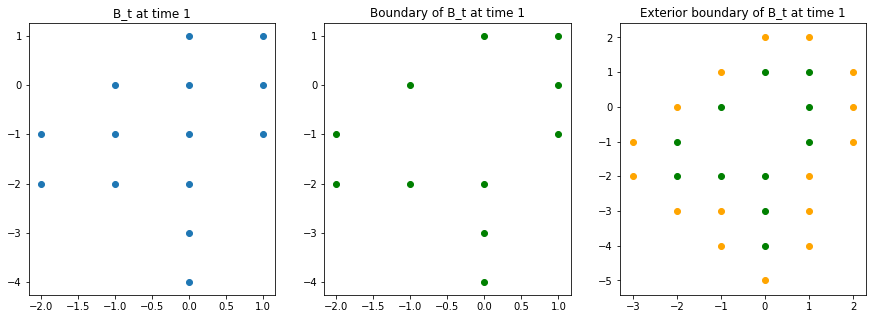

--At time 2
The number of holes is 0
The total size of holes is 0
The maximum size of holes is 0
The size of the boundary is 20
The average distance between a hole and the exterior boundary  is nan
The running minutes to complete the counting process is 0.013193682829538981


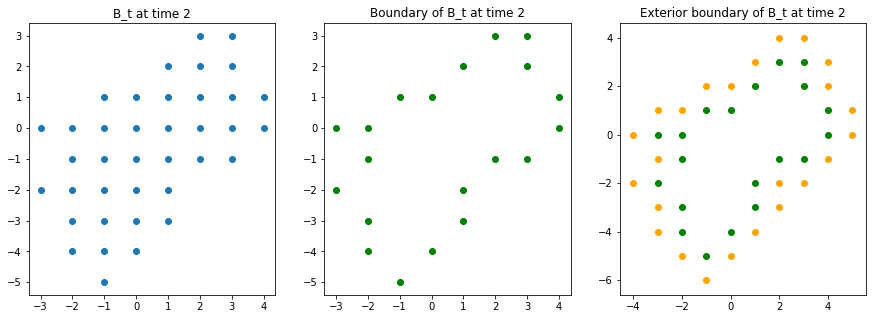

--At time 3
The number of holes is 1
The total size of holes is 1
The maximum size of holes is 1
The size of the boundary is 34
The average distance between a hole and the exterior boundary  is 2.0
The running minutes to complete the counting process is 0.013998973369598388


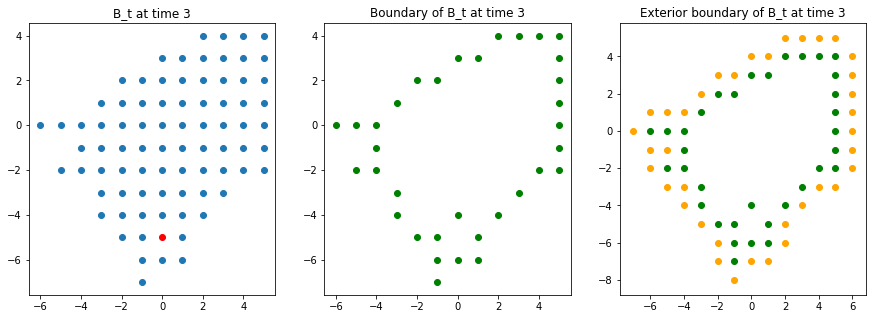

--At time 4
The number of holes is 1
The total size of holes is 1
The maximum size of holes is 1
The size of the boundary is 60
The average distance between a hole and the exterior boundary  is 1.4142135623730951
The running minutes to complete the counting process is 0.02717479070027669


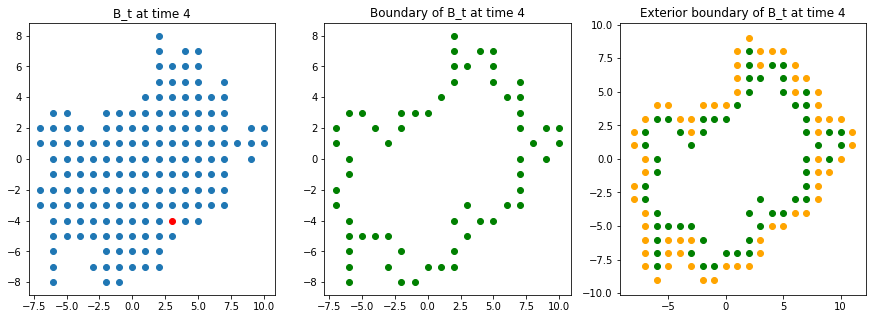

--At time 5
The number of holes is 3
The total size of holes is 3
The maximum size of holes is 1
The size of the boundary is 83
The average distance between a hole and the exterior boundary  is 1.804737854124365
The running minutes to complete the counting process is 0.0283856471379598


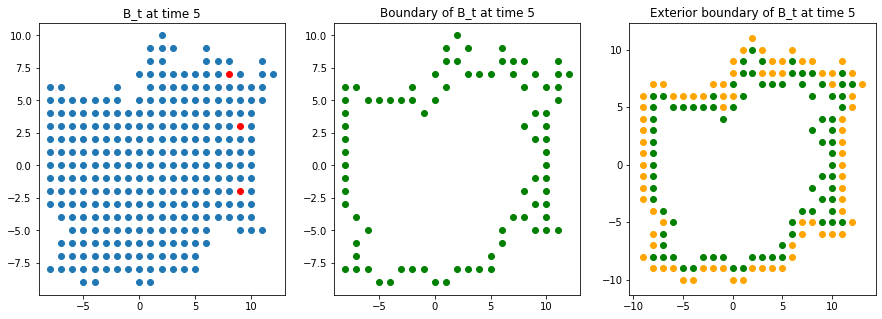

--At time 6
The number of holes is 1
The total size of holes is 1
The maximum size of holes is 1
The size of the boundary is 98
The average distance between a hole and the exterior boundary  is 1.4142135623730951
The running minutes to complete the counting process is 0.029838144779205322


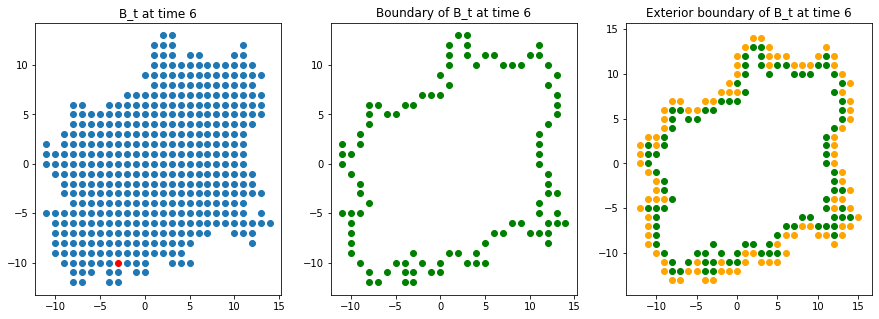

--At time 7
The number of holes is 3
The total size of holes is 3
The maximum size of holes is 1
The size of the boundary is 119
The average distance between a hole and the exterior boundary  is 1.804737854124365
The running minutes to complete the counting process is 0.023328415552775063


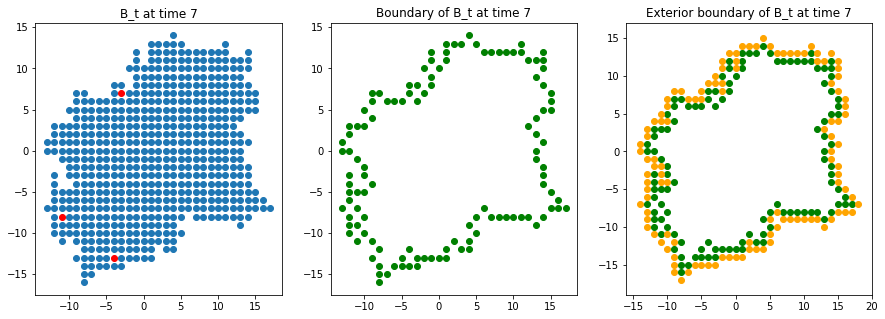

--At time 8
The number of holes is 3
The total size of holes is 5
The maximum size of holes is 3
The size of the boundary is 136
The average distance between a hole and the exterior boundary  is 1.8834271799576283
The running minutes to complete the counting process is 0.021624143918355307


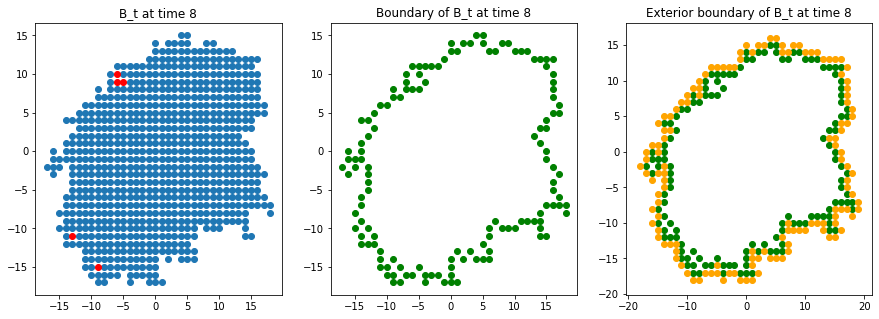

--At time 9
The number of holes is 7
The total size of holes is 7
The maximum size of holes is 1
The size of the boundary is 178
The average distance between a hole and the exterior boundary  is 2.00921358603514
The running minutes to complete the counting process is 0.018758094310760497


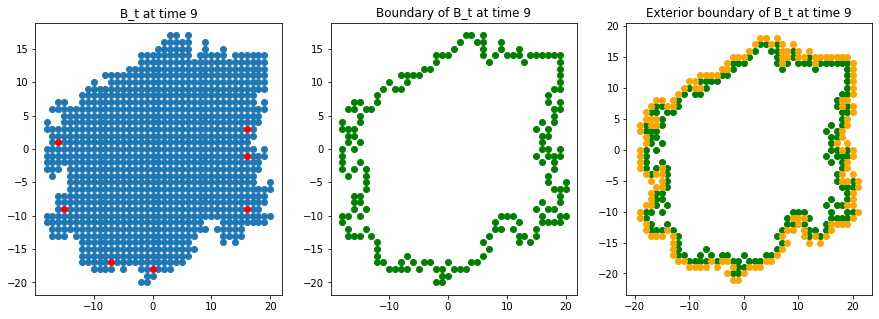

--At time 10
The number of holes is 3
The total size of holes is 3
The maximum size of holes is 1
The size of the boundary is 195
The average distance between a hole and the exterior boundary  is 2.5351837584879964
The running minutes to complete the counting process is 0.021885180473327638


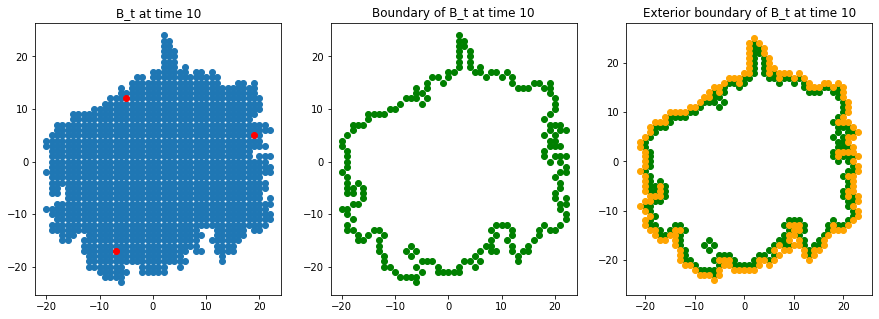

--At time 11
The number of holes is 4
The total size of holes is 4
The maximum size of holes is 1
The size of the boundary is 213
The average distance between a hole and the exterior boundary  is 2.712047990645819
The running minutes to complete the counting process is 0.01627371311187744


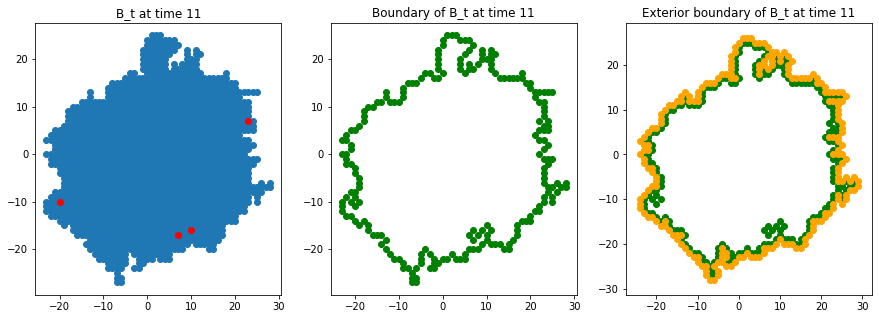

--At time 12
The number of holes is 11
The total size of holes is 16
The maximum size of holes is 5
The size of the boundary is 247
The average distance between a hole and the exterior boundary  is 2.4792600607224275
The running minutes to complete the counting process is 0.016960084438323975


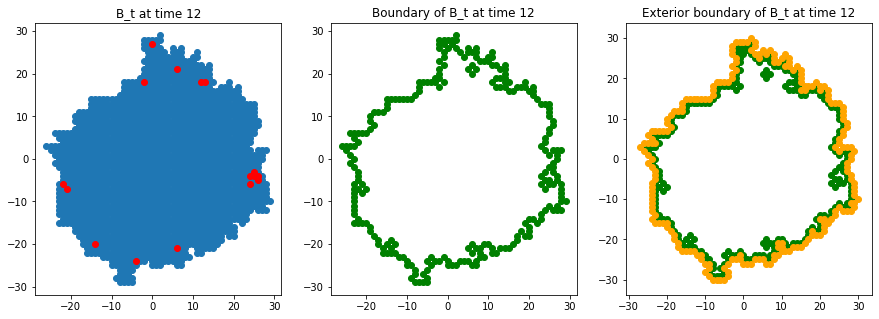

--At time 13
The number of holes is 6
The total size of holes is 10
The maximum size of holes is 3
The size of the boundary is 252
The average distance between a hole and the exterior boundary  is 2.0377954604023936
The running minutes to complete the counting process is 0.02415384848912557


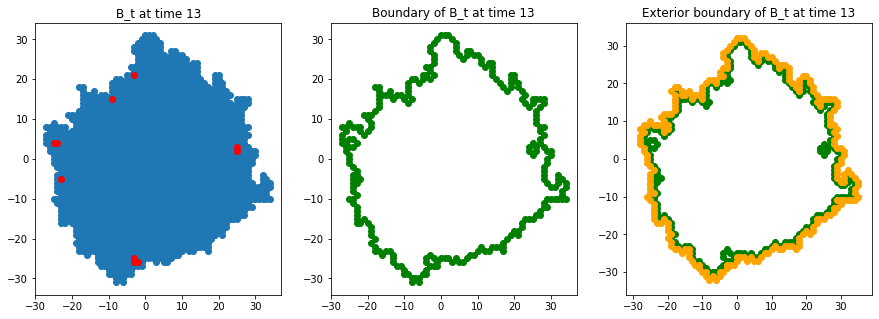

--At time 14
The number of holes is 6
The total size of holes is 6
The maximum size of holes is 1
The size of the boundary is 266
The average distance between a hole and the exterior boundary  is 2.8605857693064607
The running minutes to complete the counting process is 0.014241329828898112


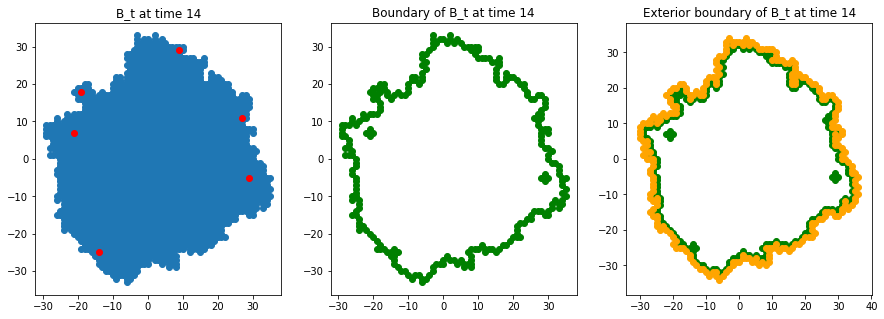

--At time 15
The number of holes is 5
The total size of holes is 6
The maximum size of holes is 2
The size of the boundary is 306
The average distance between a hole and the exterior boundary  is 2.299694700491232
The running minutes to complete the counting process is 0.014688042799631755


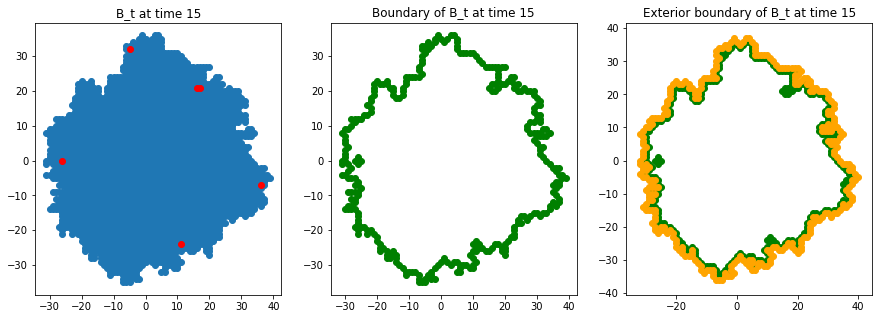

--At time 16
The number of holes is 16
The total size of holes is 20
The maximum size of holes is 3
The size of the boundary is 358
The average distance between a hole and the exterior boundary  is 2.719707382600548
The running minutes to complete the counting process is 0.015851751963297526


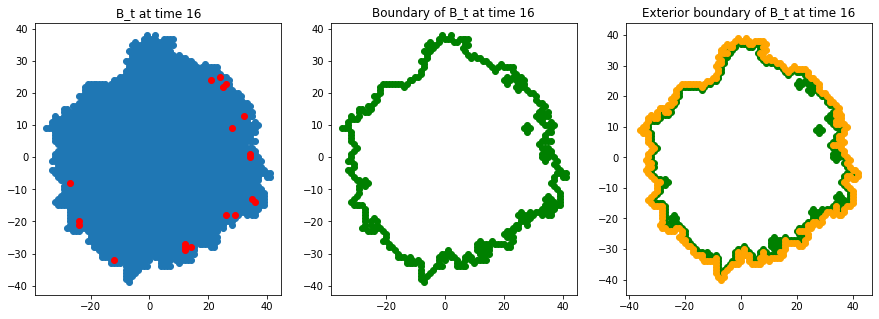

--At time 17
The number of holes is 11
The total size of holes is 15
The maximum size of holes is 4
The size of the boundary is 361
The average distance between a hole and the exterior boundary  is 2.235023475889692
The running minutes to complete the counting process is 0.016415496667226154


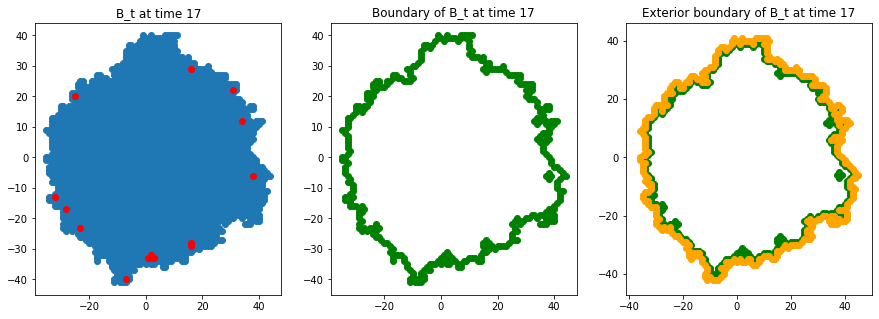

--At time 18
The number of holes is 19
The total size of holes is 28
The maximum size of holes is 4
The size of the boundary is 413
The average distance between a hole and the exterior boundary  is 2.1248122713812854
The running minutes to complete the counting process is 0.017506086826324464


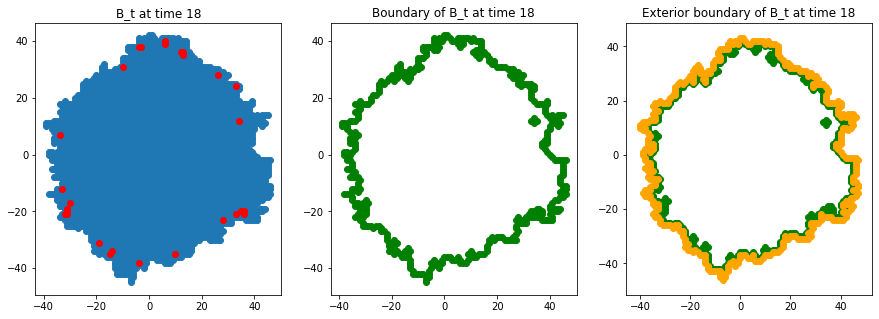

--At time 19
The number of holes is 14
The total size of holes is 21
The maximum size of holes is 4
The size of the boundary is 418
The average distance between a hole and the exterior boundary  is 2.0515249536955973
The running minutes to complete the counting process is 0.022467867533365885


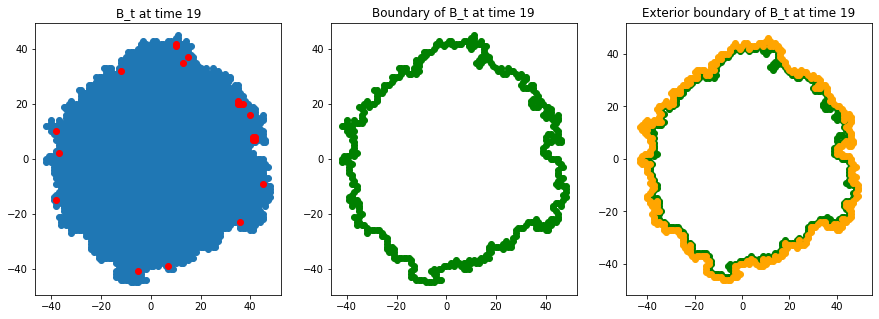

--At time 20
The number of holes is 13
The total size of holes is 17
The maximum size of holes is 4
The size of the boundary is 439
The average distance between a hole and the exterior boundary  is 1.811015674374235
The running minutes to complete the counting process is 0.017295491695404053


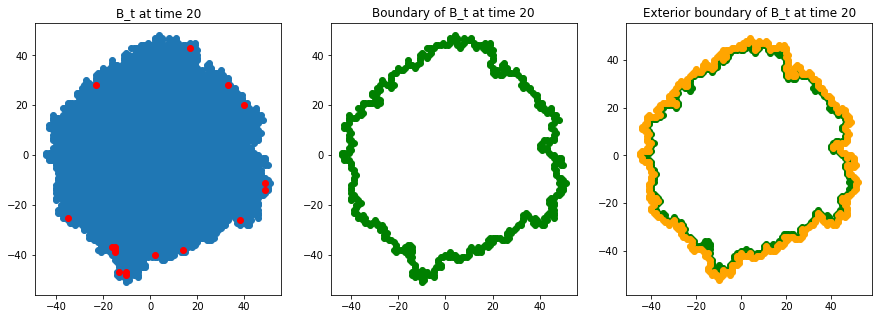

--At time 21
The number of holes is 12
The total size of holes is 16
The maximum size of holes is 3
The size of the boundary is 444
The average distance between a hole and the exterior boundary  is 2.2640433233471775
The running minutes to complete the counting process is 0.018168691794077554


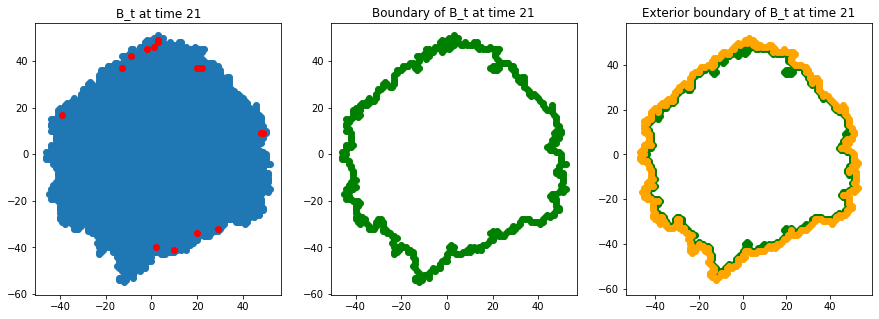

--At time 22
The number of holes is 21
The total size of holes is 34
The maximum size of holes is 4
The size of the boundary is 504
The average distance between a hole and the exterior boundary  is 1.8136384539871482
The running minutes to complete the counting process is 0.023166199525197346


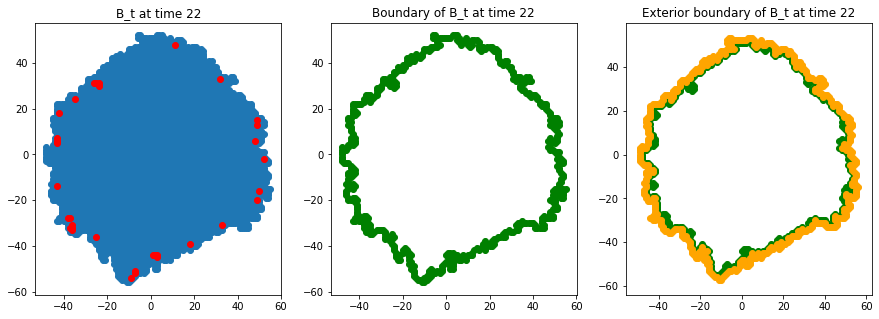

--At time 23
The number of holes is 12
The total size of holes is 16
The maximum size of holes is 3
The size of the boundary is 483
The average distance between a hole and the exterior boundary  is 2.2275670412273914
The running minutes to complete the counting process is 0.01611711581548055


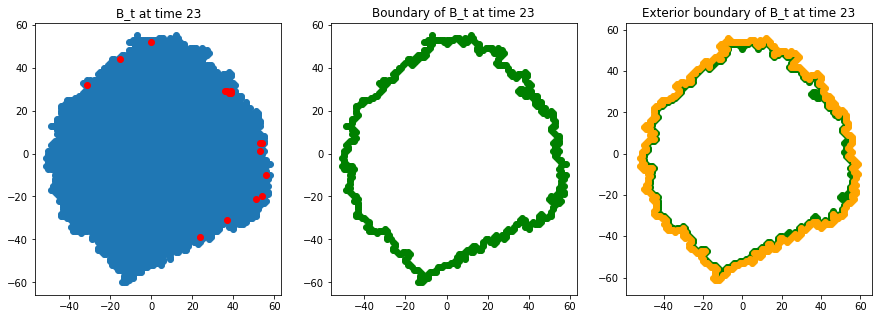

--At time 24
The number of holes is 20
The total size of holes is 27
The maximum size of holes is 3
The size of the boundary is 536
The average distance between a hole and the exterior boundary  is 2.321242155651482
The running minutes to complete the counting process is 0.015115328629811605


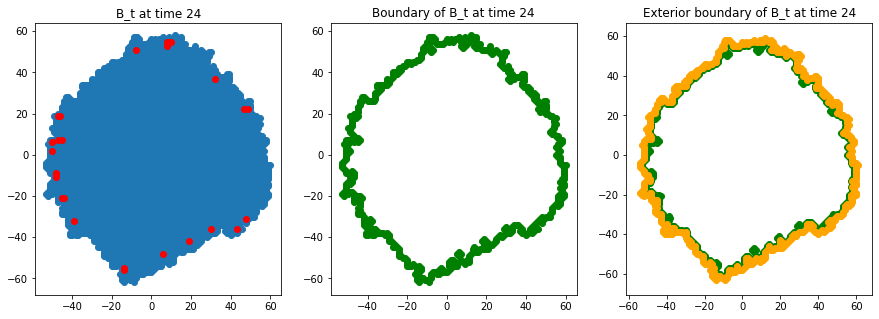

--At time 25
The number of holes is 12
The total size of holes is 13
The maximum size of holes is 2
The size of the boundary is 507
The average distance between a hole and the exterior boundary  is 2.1896166616629507
The running minutes to complete the counting process is 0.018099121252695718


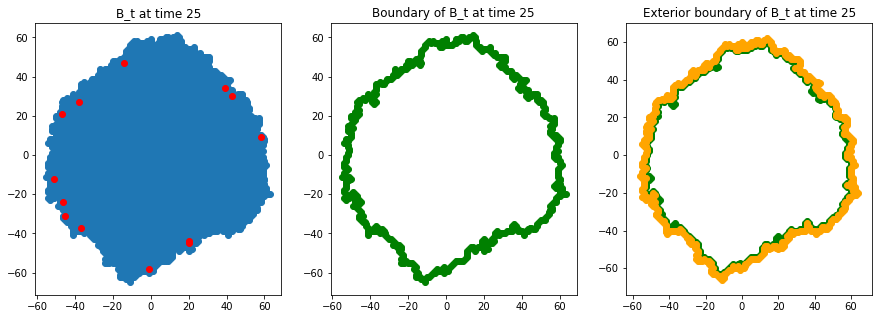

--At time 26
The number of holes is 13
The total size of holes is 14
The maximum size of holes is 2
The size of the boundary is 550
The average distance between a hole and the exterior boundary  is 2.1824331455085577
The running minutes to complete the counting process is 0.016456989447275798


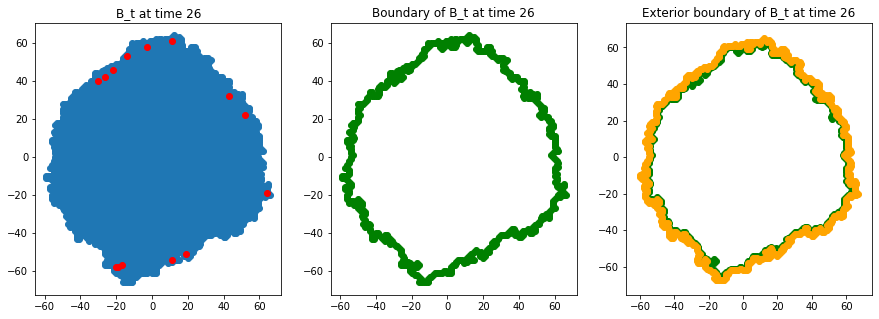

--At time 27
The number of holes is 19
The total size of holes is 28
The maximum size of holes is 4
The size of the boundary is 605
The average distance between a hole and the exterior boundary  is 2.2529169934887787
The running minutes to complete the counting process is 0.018457051118214926


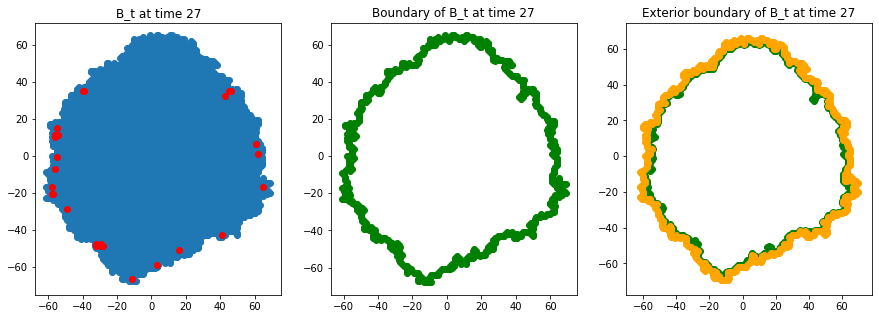

--At time 28
The number of holes is 22
The total size of holes is 30
The maximum size of holes is 4
The size of the boundary is 642
The average distance between a hole and the exterior boundary  is 1.943174295129181
The running minutes to complete the counting process is 0.024338153998057048


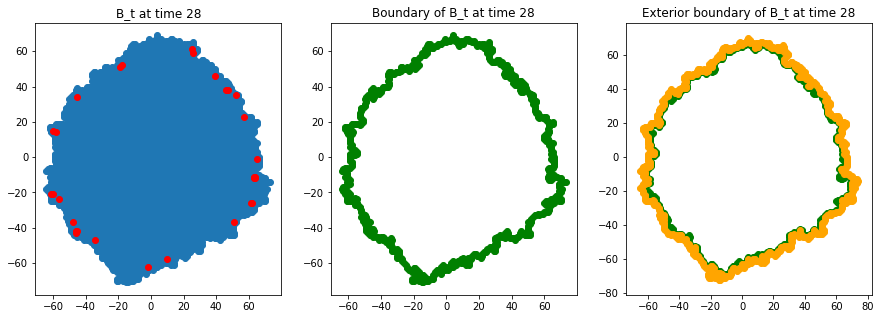

--At time 29
The number of holes is 20
The total size of holes is 21
The maximum size of holes is 2
The size of the boundary is 641
The average distance between a hole and the exterior boundary  is 2.862298699305824
The running minutes to complete the counting process is 0.017739625771840413


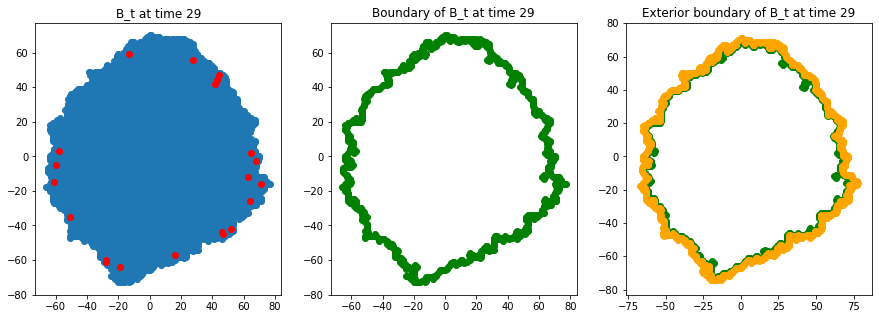

--At time 30
The number of holes is 27
The total size of holes is 35
The maximum size of holes is 2
The size of the boundary is 672
The average distance between a hole and the exterior boundary  is 1.8140747367210173
The running minutes to complete the counting process is 0.025022447109222412


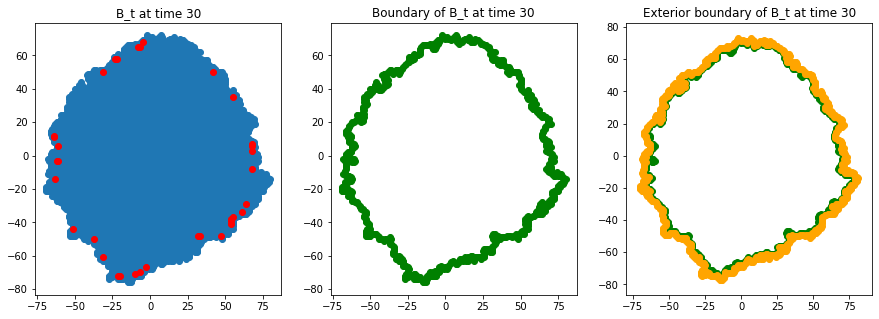

--At time 31
The number of holes is 18
The total size of holes is 22
The maximum size of holes is 4
The size of the boundary is 676
The average distance between a hole and the exterior boundary  is 1.9566568252330288
The running minutes to complete the counting process is 0.029796330134073894


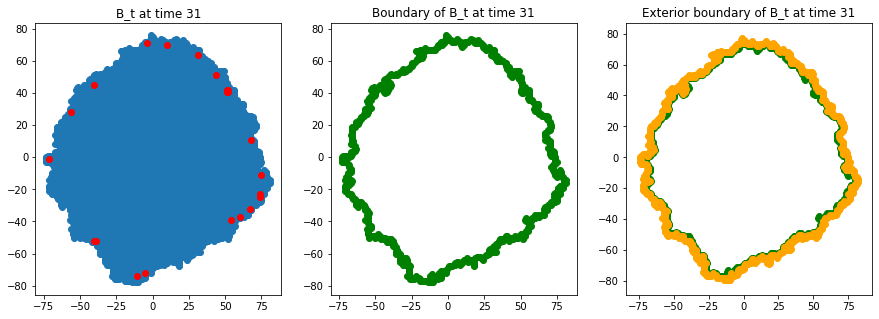

--At time 32
The number of holes is 34
The total size of holes is 41
The maximum size of holes is 3
The size of the boundary is 761
The average distance between a hole and the exterior boundary  is 1.8977215743408038
The running minutes to complete the counting process is 0.02639244794845581


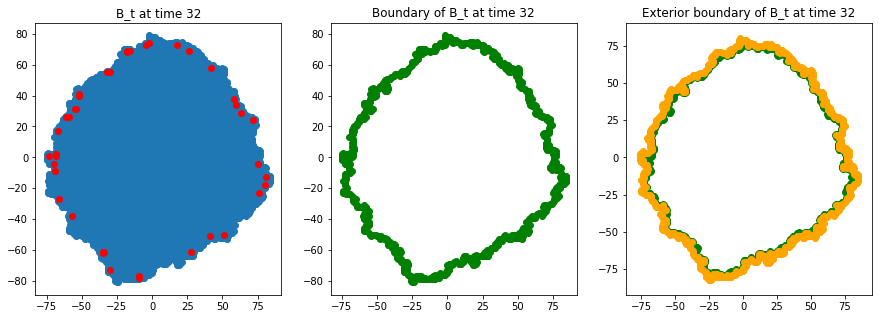

--At time 33
The number of holes is 15
The total size of holes is 19
The maximum size of holes is 3
The size of the boundary is 677
The average distance between a hole and the exterior boundary  is 2.012279339443501
The running minutes to complete the counting process is 0.025962368647257487


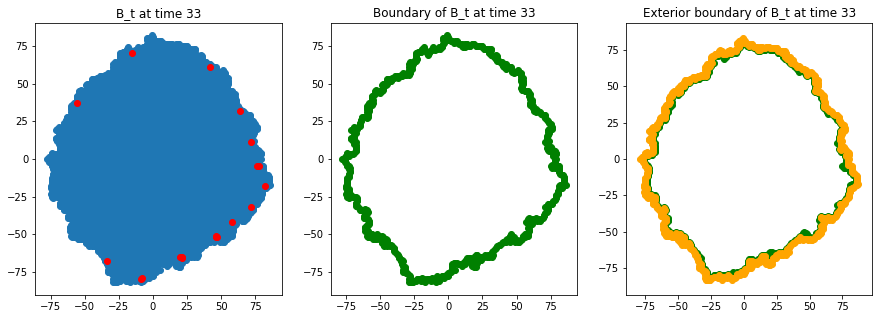

--At time 34
The number of holes is 22
The total size of holes is 26
The maximum size of holes is 3
The size of the boundary is 733
The average distance between a hole and the exterior boundary  is 2.276780031107835
The running minutes to complete the counting process is 0.06037562688191732


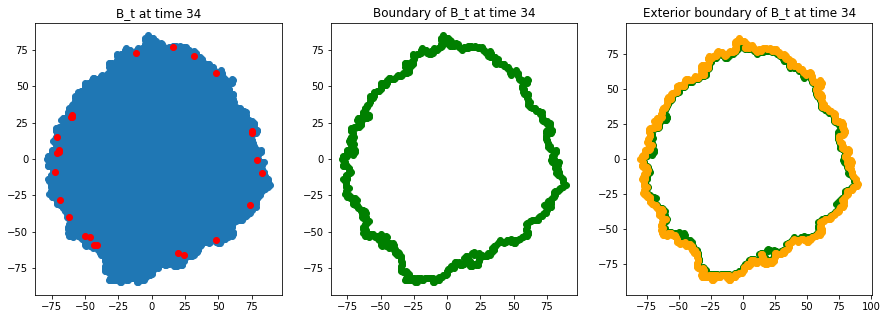

--At time 35
The number of holes is 18
The total size of holes is 24
The maximum size of holes is 3
The size of the boundary is 767
The average distance between a hole and the exterior boundary  is 1.9131181107698458
The running minutes to complete the counting process is 0.027046597003936766


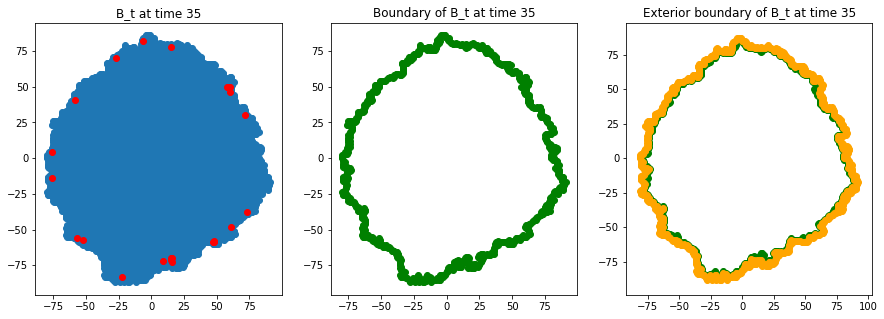

--At time 36
The number of holes is 21
The total size of holes is 27
The maximum size of holes is 3
The size of the boundary is 790
The average distance between a hole and the exterior boundary  is 2.168731604512855
The running minutes to complete the counting process is 0.023307844003041586


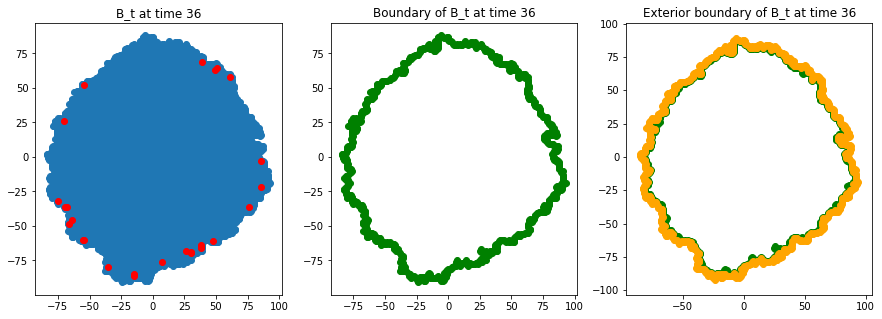

--At time 37
The number of holes is 30
The total size of holes is 48
The maximum size of holes is 6
The size of the boundary is 859
The average distance between a hole and the exterior boundary  is 2.1634700200857973
The running minutes to complete the counting process is 0.017255810896555583


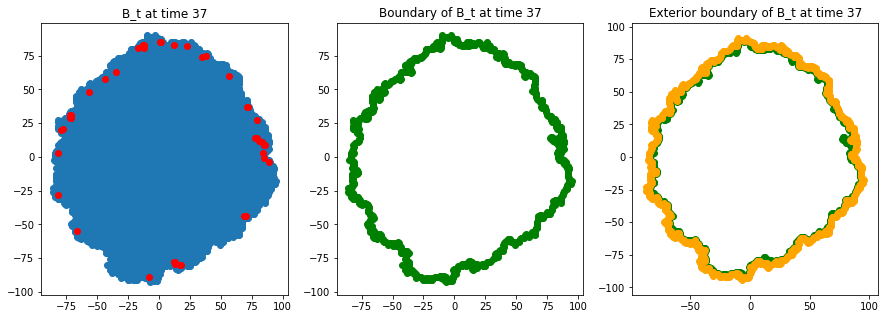

--At time 38
The number of holes is 33
The total size of holes is 44
The maximum size of holes is 4
The size of the boundary is 895
The average distance between a hole and the exterior boundary  is 2.0449208577895694
The running minutes to complete the counting process is 0.02622165282567342


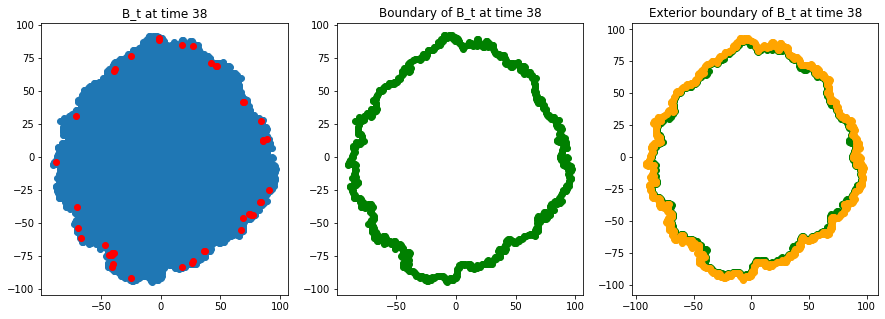

--At time 39
The number of holes is 32
The total size of holes is 42
The maximum size of holes is 5
The size of the boundary is 867
The average distance between a hole and the exterior boundary  is 2.178084107709953
The running minutes to complete the counting process is 0.01906865437825521


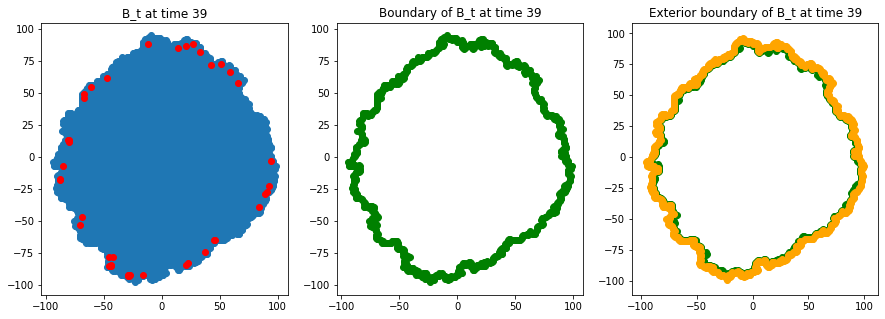

--At time 40
The number of holes is 29
The total size of holes is 37
The maximum size of holes is 4
The size of the boundary is 913
The average distance between a hole and the exterior boundary  is 2.2864394276144524
The running minutes to complete the counting process is 0.018925591309865316


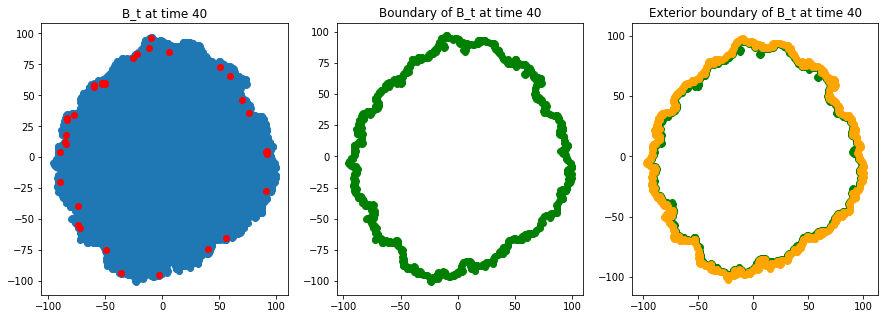

--At time 41
The number of holes is 28
The total size of holes is 38
The maximum size of holes is 4
The size of the boundary is 979
The average distance between a hole and the exterior boundary  is 2.3057112717719446
The running minutes to complete the counting process is 0.017778011163075765


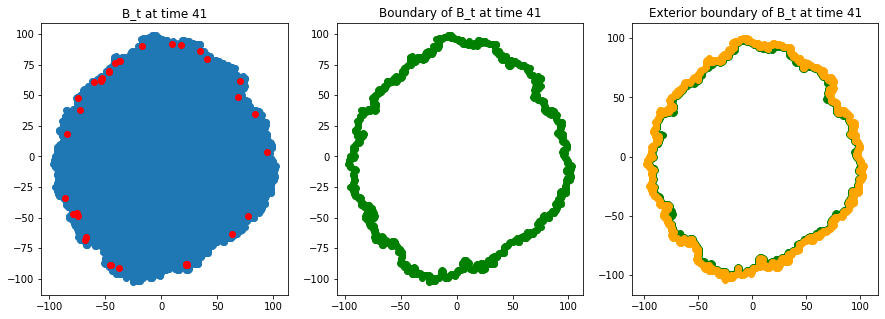

--At time 42
The number of holes is 42
The total size of holes is 57
The maximum size of holes is 5
The size of the boundary is 979
The average distance between a hole and the exterior boundary  is 1.9999136212641293
The running minutes to complete the counting process is 0.018475329875946044


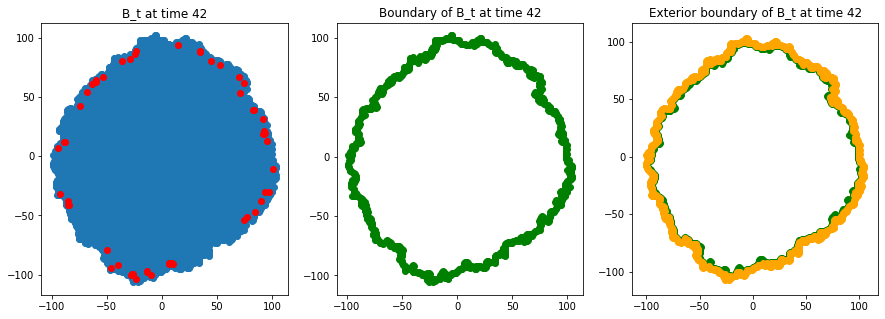

--At time 43
The number of holes is 38
The total size of holes is 44
The maximum size of holes is 2
The size of the boundary is 948
The average distance between a hole and the exterior boundary  is 2.0034719738738125
The running minutes to complete the counting process is 0.019660548369089762


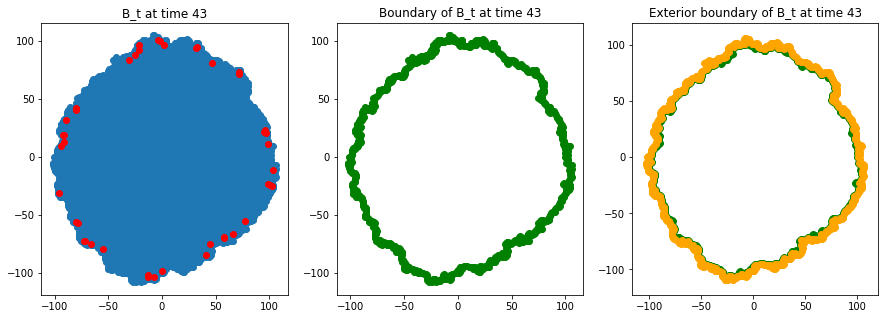

--At time 44
The number of holes is 41
The total size of holes is 55
The maximum size of holes is 5
The size of the boundary is 1014
The average distance between a hole and the exterior boundary  is 2.0712172190066993
The running minutes to complete the counting process is 0.02422256072362264


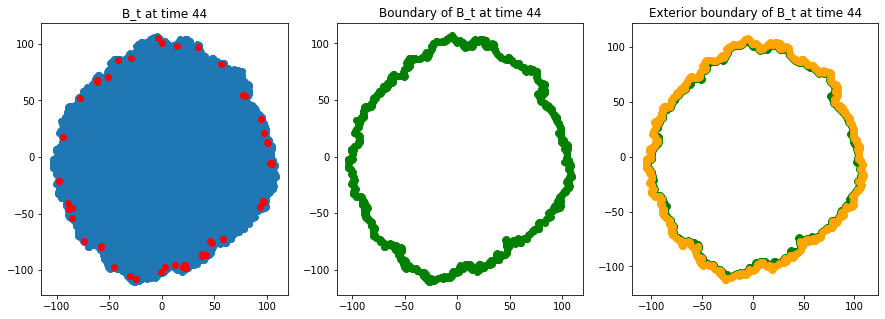

--At time 45
The number of holes is 31
The total size of holes is 47
The maximum size of holes is 4
The size of the boundary is 997
The average distance between a hole and the exterior boundary  is 2.1678573461577173
The running minutes to complete the counting process is 0.02063249349594116


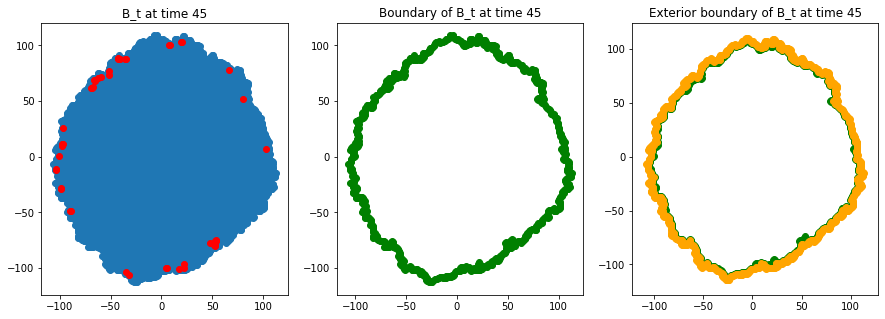

--At time 46
The number of holes is 36
The total size of holes is 46
The maximum size of holes is 5
The size of the boundary is 1064
The average distance between a hole and the exterior boundary  is 2.068569668002583
The running minutes to complete the counting process is 0.028117140134175617


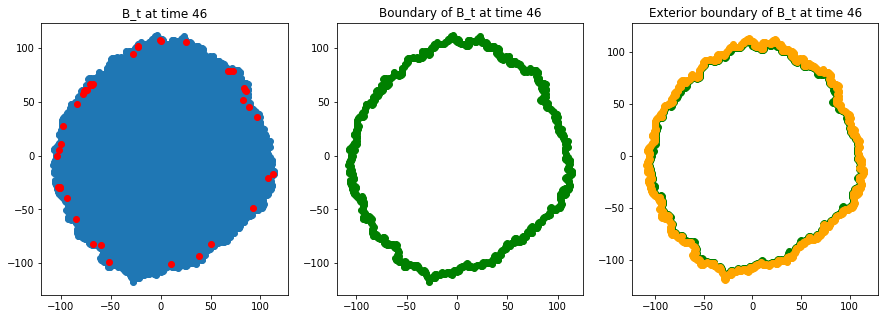

--At time 47
The number of holes is 29
The total size of holes is 32
The maximum size of holes is 2
The size of the boundary is 1048
The average distance between a hole and the exterior boundary  is 2.326228820809537
The running minutes to complete the counting process is 0.0623771071434021


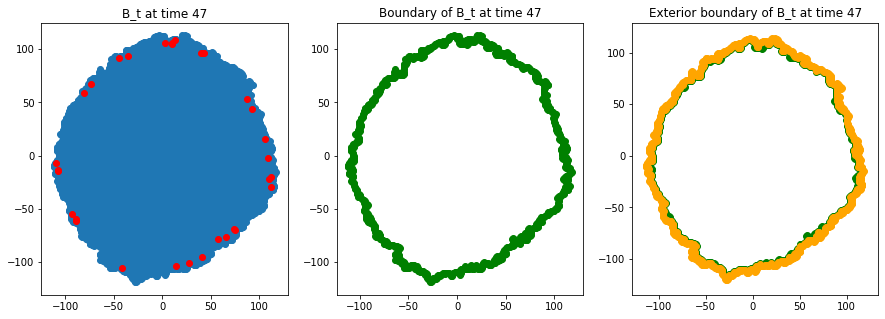

--At time 48
The number of holes is 52
The total size of holes is 63
The maximum size of holes is 3
The size of the boundary is 1124
The average distance between a hole and the exterior boundary  is 2.2297114600472447
The running minutes to complete the counting process is 0.023611382643381754


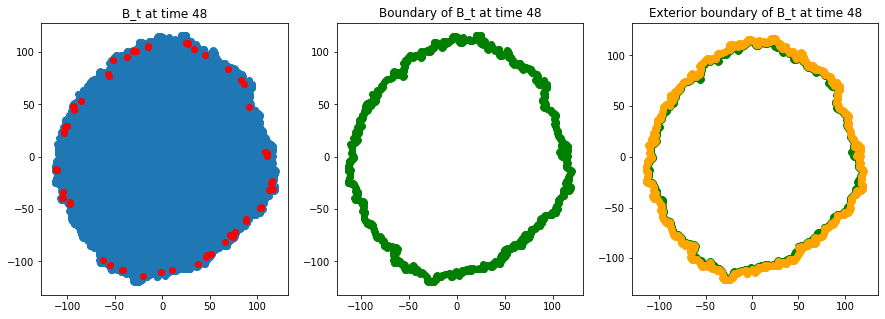

--At time 49
The number of holes is 29
The total size of holes is 40
The maximum size of holes is 5
The size of the boundary is 1138
The average distance between a hole and the exterior boundary  is 2.2605459407223334
The running minutes to complete the counting process is 0.032416828473409015


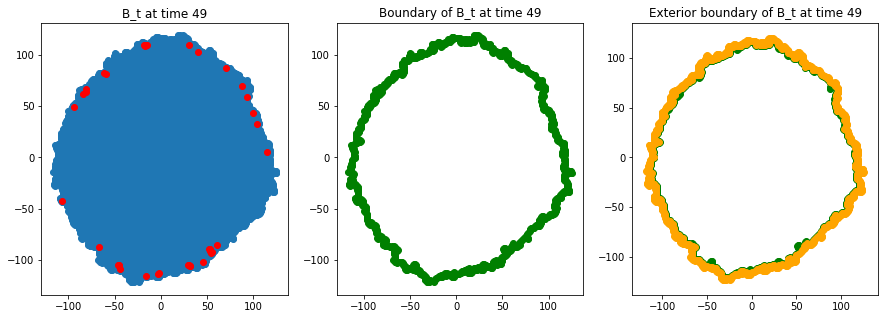

--At time 50
The number of holes is 33
The total size of holes is 47
The maximum size of holes is 4
The size of the boundary is 1188
The average distance between a hole and the exterior boundary  is 2.1454159224264426
The running minutes to complete the counting process is 0.05714260339736939


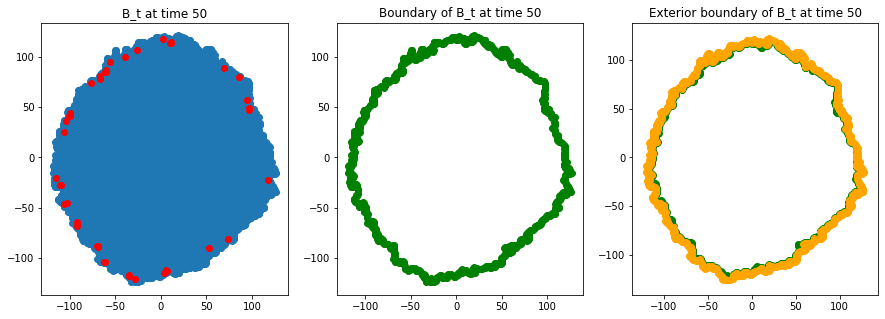

--At time 51
The number of holes is 43
The total size of holes is 68
The maximum size of holes is 4
The size of the boundary is 1212
The average distance between a hole and the exterior boundary  is 2.0306133409688405
The running minutes to complete the counting process is 0.03402148087819417


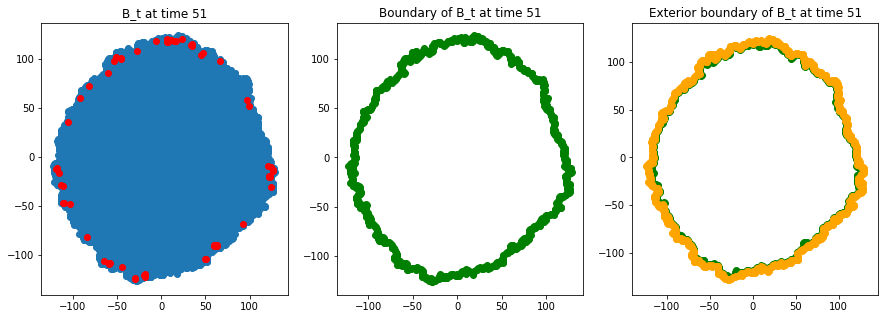

--At time 52
The number of holes is 42
The total size of holes is 54
The maximum size of holes is 5
The size of the boundary is 1222
The average distance between a hole and the exterior boundary  is 2.2498892216847657
The running minutes to complete the counting process is 0.04154164393742879


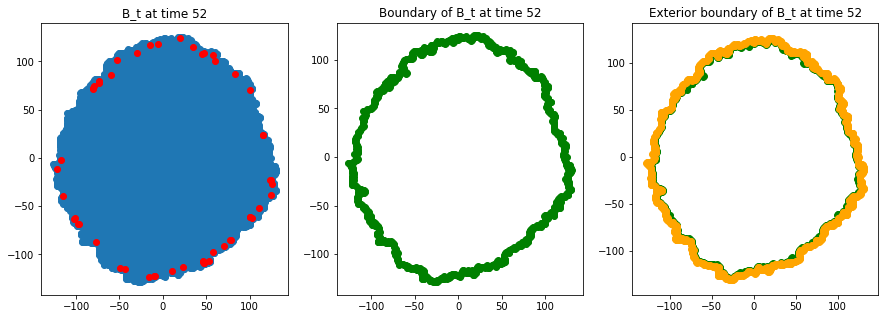

--At time 53
The number of holes is 39
The total size of holes is 50
The maximum size of holes is 5
The size of the boundary is 1229
The average distance between a hole and the exterior boundary  is 2.185110119265493
The running minutes to complete the counting process is 0.06320272286732992


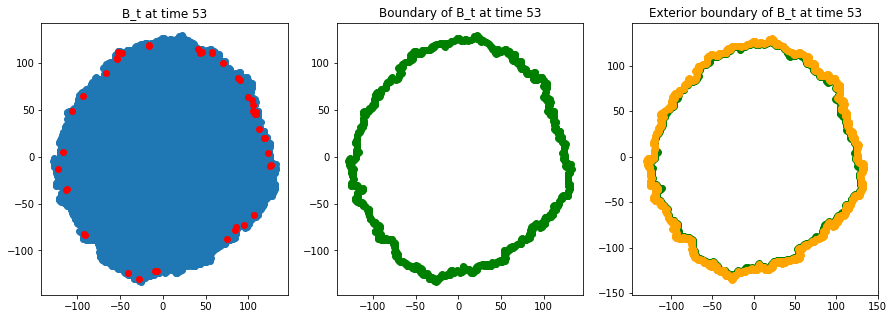

--At time 54
The number of holes is 50
The total size of holes is 72
The maximum size of holes is 5
The size of the boundary is 1253
The average distance between a hole and the exterior boundary  is 2.055512876749166
The running minutes to complete the counting process is 0.05227204958597819


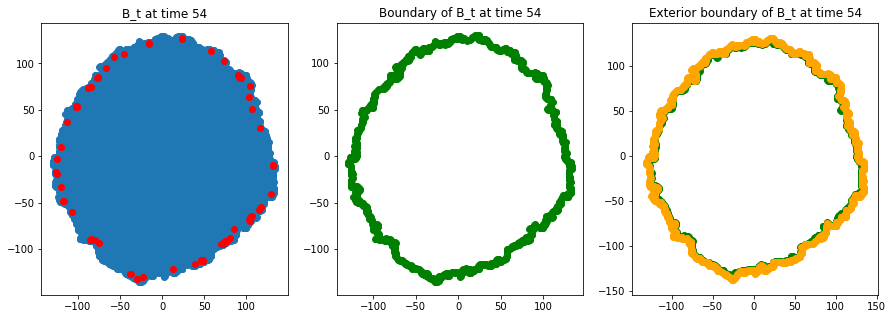

--At time 55
The number of holes is 39
The total size of holes is 50
The maximum size of holes is 5
The size of the boundary is 1283
The average distance between a hole and the exterior boundary  is 2.166069100307262
The running minutes to complete the counting process is 0.04348960320154826


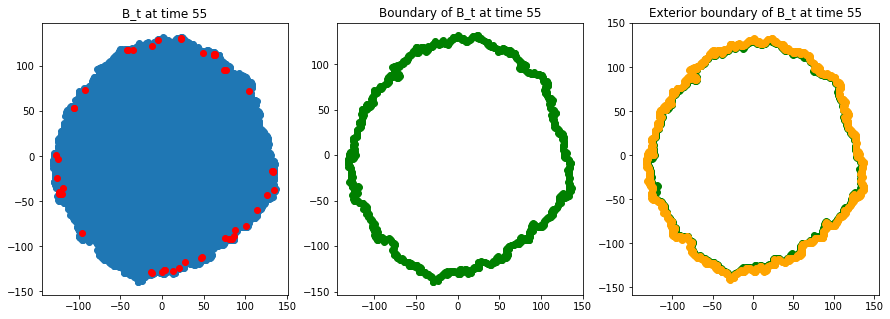

--At time 56
The number of holes is 35
The total size of holes is 49
The maximum size of holes is 5
The size of the boundary is 1289
The average distance between a hole and the exterior boundary  is 2.4583625641857103
The running minutes to complete the counting process is 0.022808174292246502


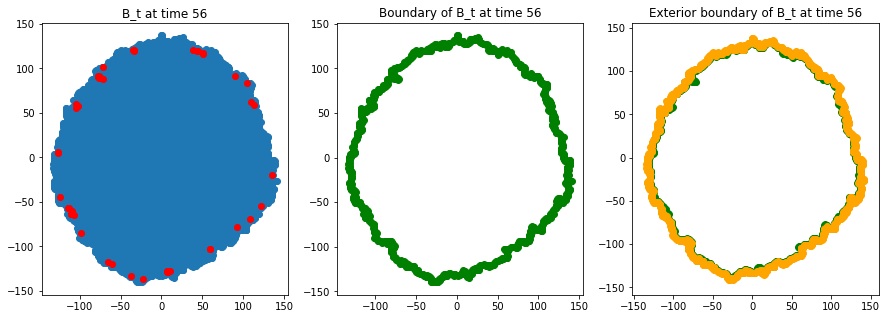

--At time 57
The number of holes is 53
The total size of holes is 71
The maximum size of holes is 3
The size of the boundary is 1397
The average distance between a hole and the exterior boundary  is 2.189107897438018
The running minutes to complete the counting process is 0.02567532459894816


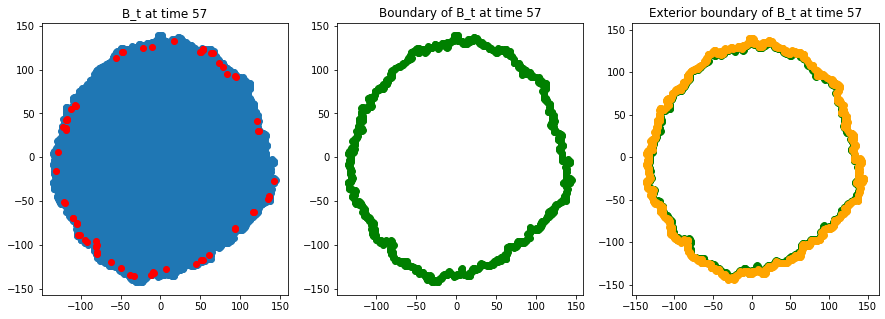

--At time 58
The number of holes is 57
The total size of holes is 78
The maximum size of holes is 8
The size of the boundary is 1378
The average distance between a hole and the exterior boundary  is 2.2536495153742337
The running minutes to complete the counting process is 0.02636619806289673


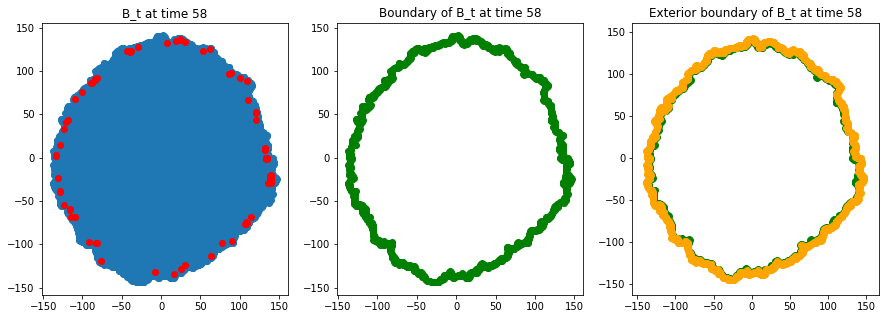

--At time 59
The number of holes is 43
The total size of holes is 47
The maximum size of holes is 2
The size of the boundary is 1347
The average distance between a hole and the exterior boundary  is 1.965513686433848
The running minutes to complete the counting process is 0.024207786719004313


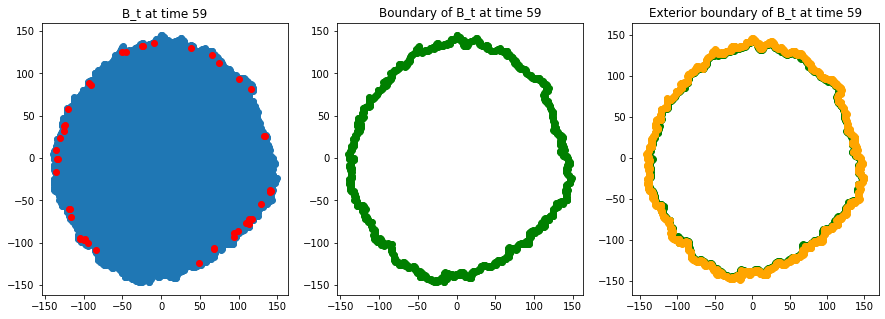

--At time 60
The number of holes is 49
The total size of holes is 69
The maximum size of holes is 5
The size of the boundary is 1370
The average distance between a hole and the exterior boundary  is 1.9969579398383193
The running minutes to complete the counting process is 0.02511782248814901


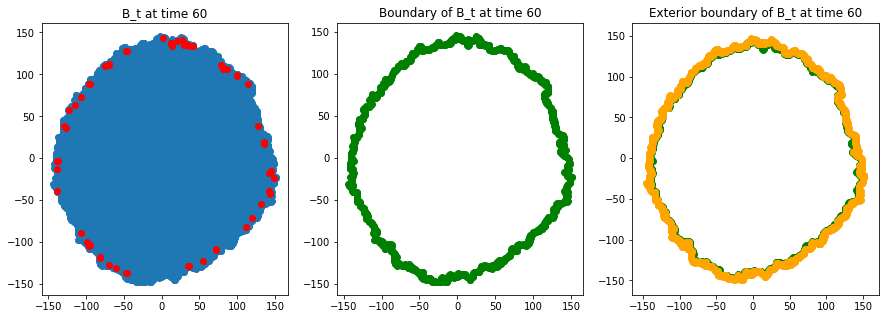

--At time 61
The number of holes is 48
The total size of holes is 59
The maximum size of holes is 2
The size of the boundary is 1407
The average distance between a hole and the exterior boundary  is 2.102933415229115
The running minutes to complete the counting process is 0.02532071669896444


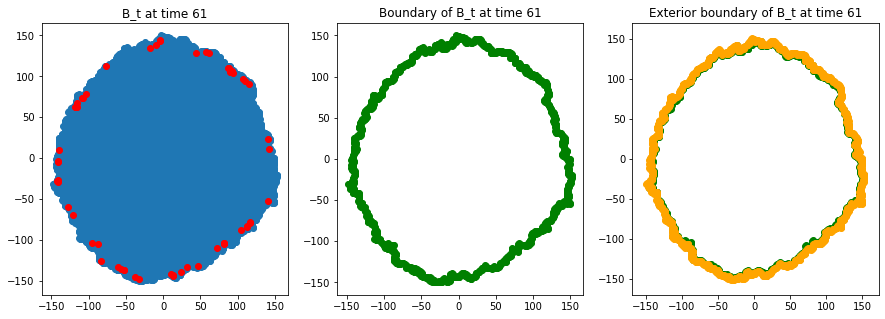

--At time 62
The number of holes is 44
The total size of holes is 56
The maximum size of holes is 4
The size of the boundary is 1456
The average distance between a hole and the exterior boundary  is 2.1402913312710696
The running minutes to complete the counting process is 0.023877028624216715


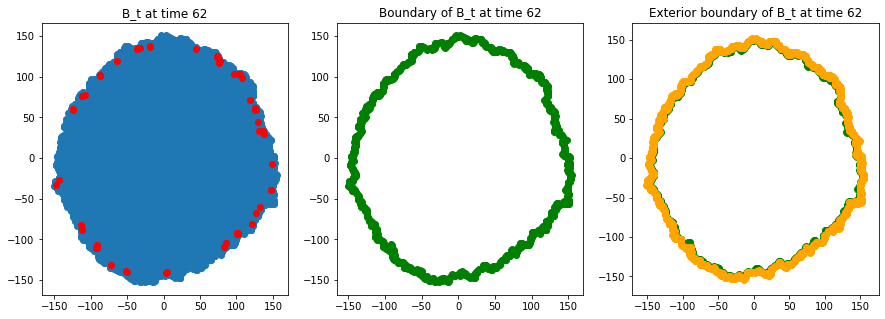

--At time 63
The number of holes is 51
The total size of holes is 76
The maximum size of holes is 6
The size of the boundary is 1492
The average distance between a hole and the exterior boundary  is 2.3376011387288322
The running minutes to complete the counting process is 0.024543635050455728


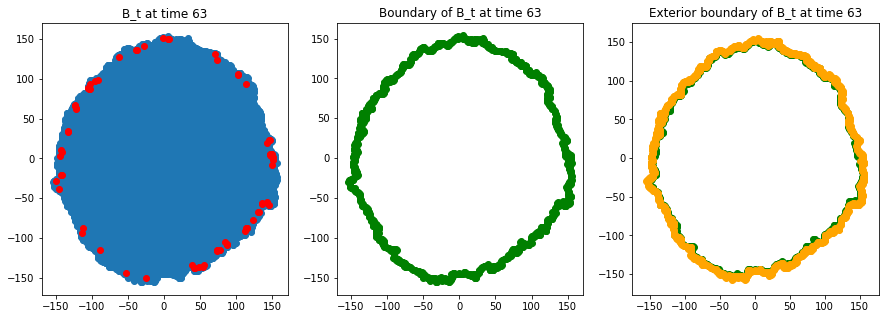

--At time 64
The number of holes is 60
The total size of holes is 79
The maximum size of holes is 6
The size of the boundary is 1549
The average distance between a hole and the exterior boundary  is 2.1570729546588576
The running minutes to complete the counting process is 0.045144983132680255


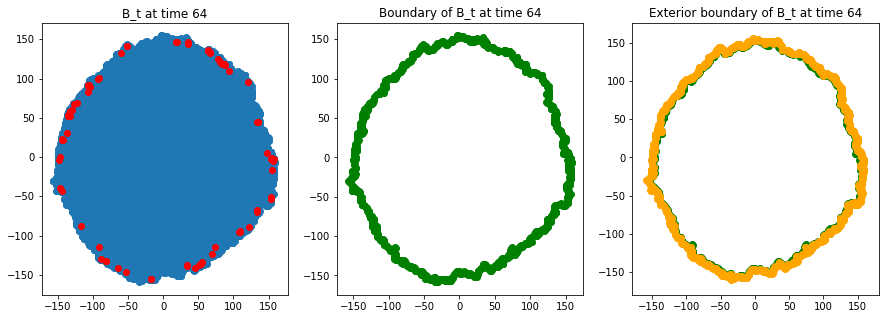

--At time 65
The number of holes is 43
The total size of holes is 48
The maximum size of holes is 5
The size of the boundary is 1493
The average distance between a hole and the exterior boundary  is 2.14399747796905
The running minutes to complete the counting process is 0.025607728958129884


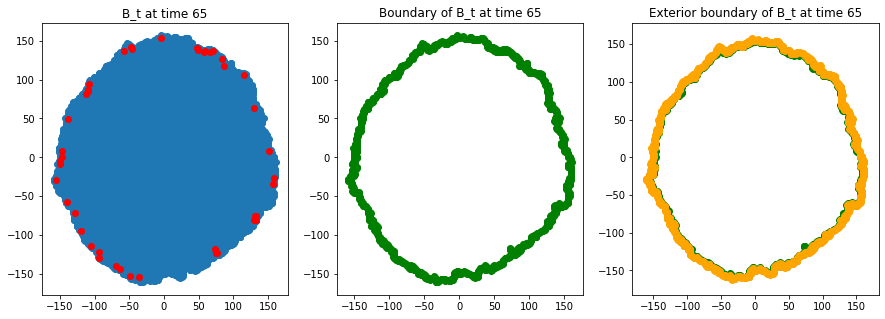

--At time 66
The number of holes is 55
The total size of holes is 71
The maximum size of holes is 6
The size of the boundary is 1554
The average distance between a hole and the exterior boundary  is 2.2451543519371695
The running minutes to complete the counting process is 0.02661553621292114


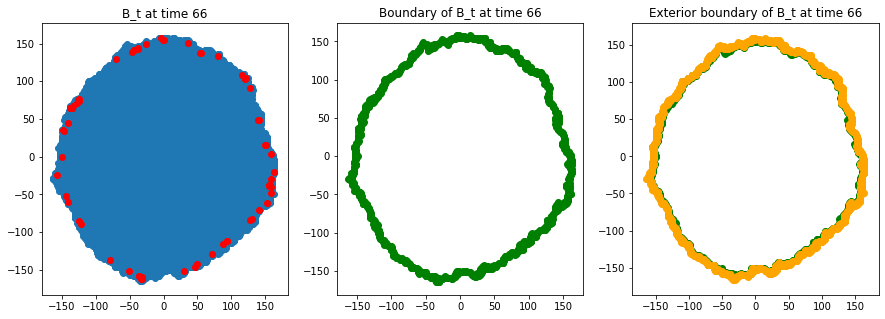

--At time 67
The number of holes is 46
The total size of holes is 60
The maximum size of holes is 3
The size of the boundary is 1498
The average distance between a hole and the exterior boundary  is 2.0342543269571114
The running minutes to complete the counting process is 0.042195852597554526


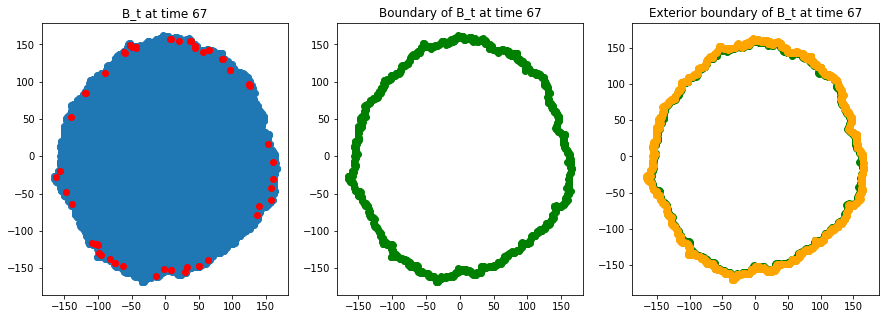

--At time 68
The number of holes is 41
The total size of holes is 48
The maximum size of holes is 3
The size of the boundary is 1559
The average distance between a hole and the exterior boundary  is 2.2207949237856925
The running minutes to complete the counting process is 0.031134053071339925


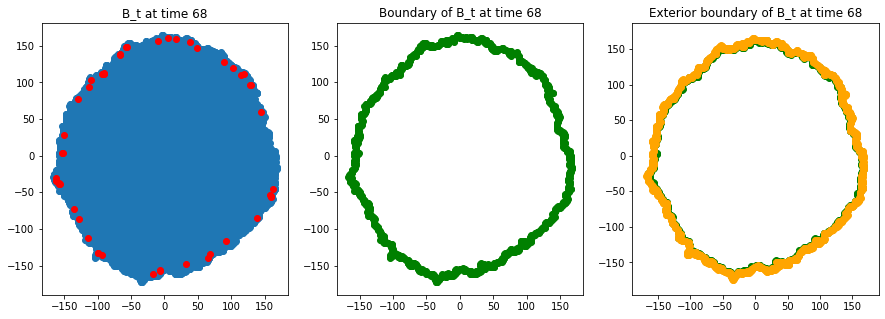

--At time 69
The number of holes is 48
The total size of holes is 68
The maximum size of holes is 9
The size of the boundary is 1630
The average distance between a hole and the exterior boundary  is 2.347455443323664
The running minutes to complete the counting process is 0.035798450311024986


KeyboardInterrupt: 

In [ ]:
time_list = list(range(1, 260, 1))    
result_fp_pareto= generate_First_Percolation_2d(D = 1000, count_time_list = time_list, distribution = 'Exponential', paras = [1], if_print = 1)

--At time 1000
The number of holes is 1003
The total size of holes is 1575
The maximum size of holes is 18
The size of the boundary is 12083
The average distance between a hole and the exterior boundary  is 9.555044042426406
The running minutes to complete the counting process is 0.7447181383768717


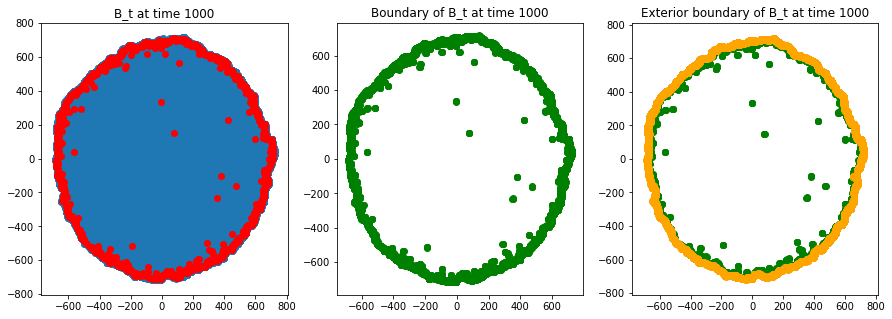

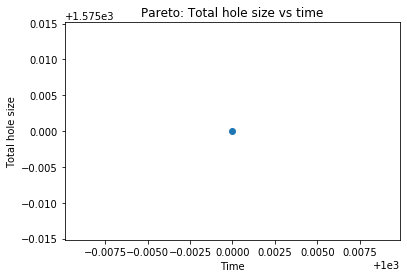

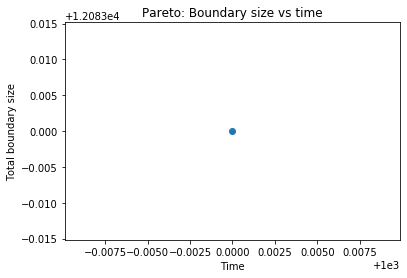

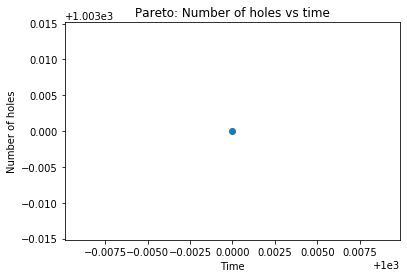

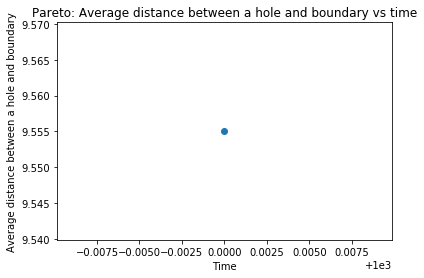

The total running minutes of B_t is 3.7519041299819946


In [9]:
time_list = [1000]
result_fp_pareto= generate_First_Percolation_2d(D = 1500, count_time_list = time_list, distribution = 'Pareto', paras = [0.5], if_print = 1)

--At time 100
The number of holes is 67
The total size of holes is 89
The maximum size of holes is 9
The size of the boundary is 2348
The average distance between a hole and the exterior boundary  is 2.0112507865519587
The running minutes to complete the counting process is 0.36454374392827354


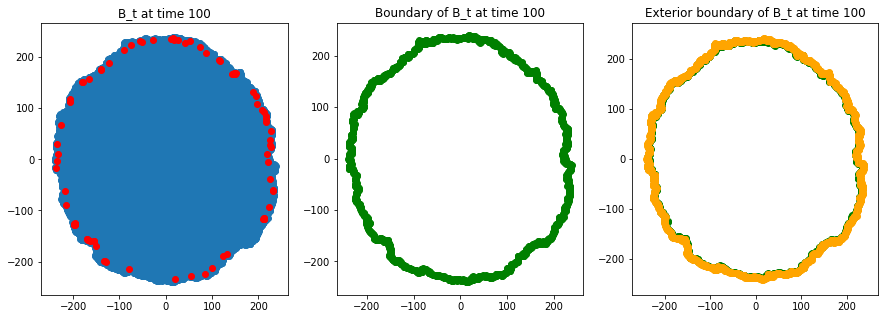

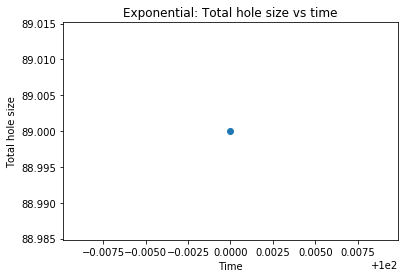

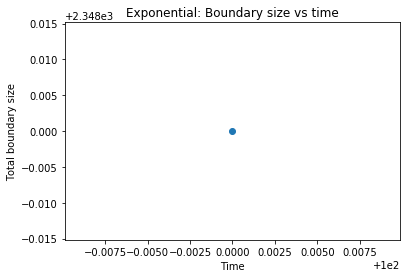

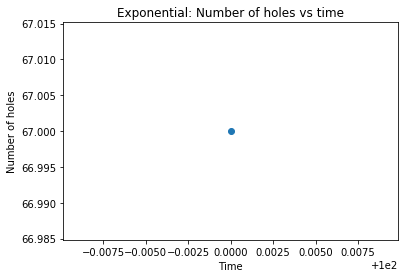

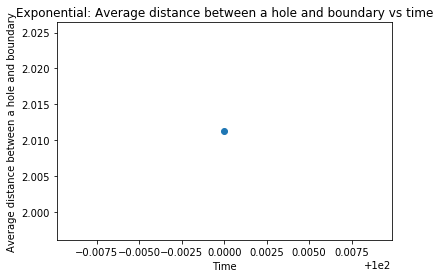

The total running minutes of B_t is 3.2818472027778625


In [11]:
time_list = [100]
result_fp_pareto= generate_First_Percolation_2d(D = 1500, count_time_list = time_list, distribution = 'Exponential', paras = [1], if_print = 1)